# YOLOv8 model for Underwater Object Detection

This is a replication of the model/architecture purposed in **A lightweight YOLOv8 integrating FasterNet for real-time underwater object detection**. The paper can be found at [this link](https://www.researchgate.net/publication/378873018_A_lightweight_YOLOv8_integrating_FasterNet_for_real-time_underwater_object_detection). 

## Dataset Setup

Using the RUOD dataset:

- Download the dataset from [here](https://github.com/xiaoDetection/RUOD?tab=readme-ov-file). I recommend using the Google option.
- Create ./data folder within the model. (Like this: ./uw-yolov8/data)
- Place the downloaded .zip file inside the data-folder
- Then unzip it manually or running code below:

In [3]:
import zipfile
import os

zip_path = "data/RUOD.zip"
extract_dir = "data/RUOD/"

# Make sure the target directory exists
os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("✅ RUOD dataset extracted to:", os.path.abspath(extract_dir))


✅ RUOD dataset extracted to: /cluster/home/henrban/SOLAQUA-UOD/uw_yolov8/data/RUOD


### Make labels on right format. COCO -> YOLO

In [4]:
import json, os
from pathlib import Path
from collections import defaultdict

ROOT = Path("data/RUOD")
IMAGES = ROOT/"RUOD_pic"
ANN    = ROOT/"RUOD_ANN"

def clip(v, lo, hi): return max(lo, min(hi, v))

def convert(split, coco_json):
    labels_dir = ROOT/"labels"/split
    labels_dir.mkdir(parents=True, exist_ok=True)
    coco = json.loads(Path(coco_json).read_text())

    id2img = {im["id"]: im for im in coco["images"]}
    byimg = defaultdict(list)
    for a in coco["annotations"]:
        if a.get("iscrowd",0)==1 or a.get("ignore",0)==1:
            continue
        byimg[a["image_id"]].append(a)

    # build contiguous class map from categories order
    sorted_cats = sorted(coco["categories"], key=lambda c: c["id"])
    cat2idx = {c["id"]: i for i,c in enumerate(sorted_cats)}

    written = 0
    for img_id, img in id2img.items():
        img_path = IMAGES/split/img["file_name"]
        if not img_path.exists():
            continue
        W,H = img["width"], img["height"]
        lines=[]
        for ann in byimg.get(img_id, []):
            x,y,w,h = ann["bbox"]
            x = clip(x,0,W); y = clip(y,0,H)
            w = clip(w,0,W-x); h = clip(h,0,H-y)
            if w<=0 or h<=0: continue
            xc = (x+w/2)/W; yc=(y+h/2)/H
            wn = w/W; hn=h/H
            cls = cat2idx[ann["category_id"]]
            lines.append(f"{cls} {xc:.6f} {yc:.6f} {wn:.6f} {hn:.6f}")
        if lines:
            (labels_dir/(Path(img["file_name"]).stem+".txt")).write_text("\n".join(lines))
            written+=1
    print(f"{split}: wrote labels for {written} images")

convert("train", ANN/"instances_train.json")
convert("test",  ANN/"instances_test.json")


train: wrote labels for 9800 images
test: wrote labels for 4200 images


### Check Paths for data

In [5]:
from pathlib import Path
ROOT = Path.cwd()              # your notebook folder (where uw_yolov8 lives)
DATA = ROOT / "data" / "RUOD"  # the folder where you unzipped RUOD


# Your layout from the screenshots:
IMAGES_TRAIN = DATA / "RUOD_pic" / "train"
IMAGES_VAL   = DATA / "RUOD_pic" / "test"      # use "test" as val; add a real val split later if you prefer
LABELS_TRAIN = DATA / "labels" / "train"
LABELS_VAL   = DATA / "labels" / "test"

# Quick checks
for p in [IMAGES_TRAIN, IMAGES_VAL, LABELS_TRAIN, LABELS_VAL]:
    print(p, "OK" if p.exists() else "MISSING")


/cluster/home/henrban/SOLAQUA-UOD/uw_yolov8/data/RUOD/RUOD_pic/train OK
/cluster/home/henrban/SOLAQUA-UOD/uw_yolov8/data/RUOD/RUOD_pic/test OK
/cluster/home/henrban/SOLAQUA-UOD/uw_yolov8/data/RUOD/labels/train OK
/cluster/home/henrban/SOLAQUA-UOD/uw_yolov8/data/RUOD/labels/test OK


### Write yaml config file

In [6]:
from pathlib import Path
ROOT = Path.cwd()
DATA = ROOT / "data" / "RUOD"

IMAGES_TRAIN = DATA / "images" / "train"
IMAGES_VAL   = DATA / "images" / "test"        # or use a dedicated val split if you have one

dataset_yaml = f"""
train: {IMAGES_TRAIN.as_posix()}
val:   {IMAGES_VAL.as_posix()}
test:  {IMAGES_VAL.as_posix()}

# RUOD has 10 classes
names:
  - holothurian
  - echinus
  - scallop
  - starfish
  - fish
  - coral
  - diver
  - cuttlefish
  - turtle
  - jellyfish
"""
(DATA / "ruod.yaml").write_text(dataset_yaml)
print("Wrote:", DATA / "ruod.yaml")


Wrote: /cluster/home/henrban/SOLAQUA-UOD/uw_yolov8/data/RUOD/ruod.yaml


### Now lets vizualise some data:


In [ ]:
# If these are not installed, run these lines:
pip install opencv-python
pip install matplotlib

  Using cached opencv_python-4.12.0.88-cp37-abi3-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (19 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 87.9 MB/s  0:00:00m eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.5/19.5 MB 90.9 MB/s  0:00:006m0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [opencv-python]0m [opencv-python]
Note: you may need to restart the kernel to use updated packages.


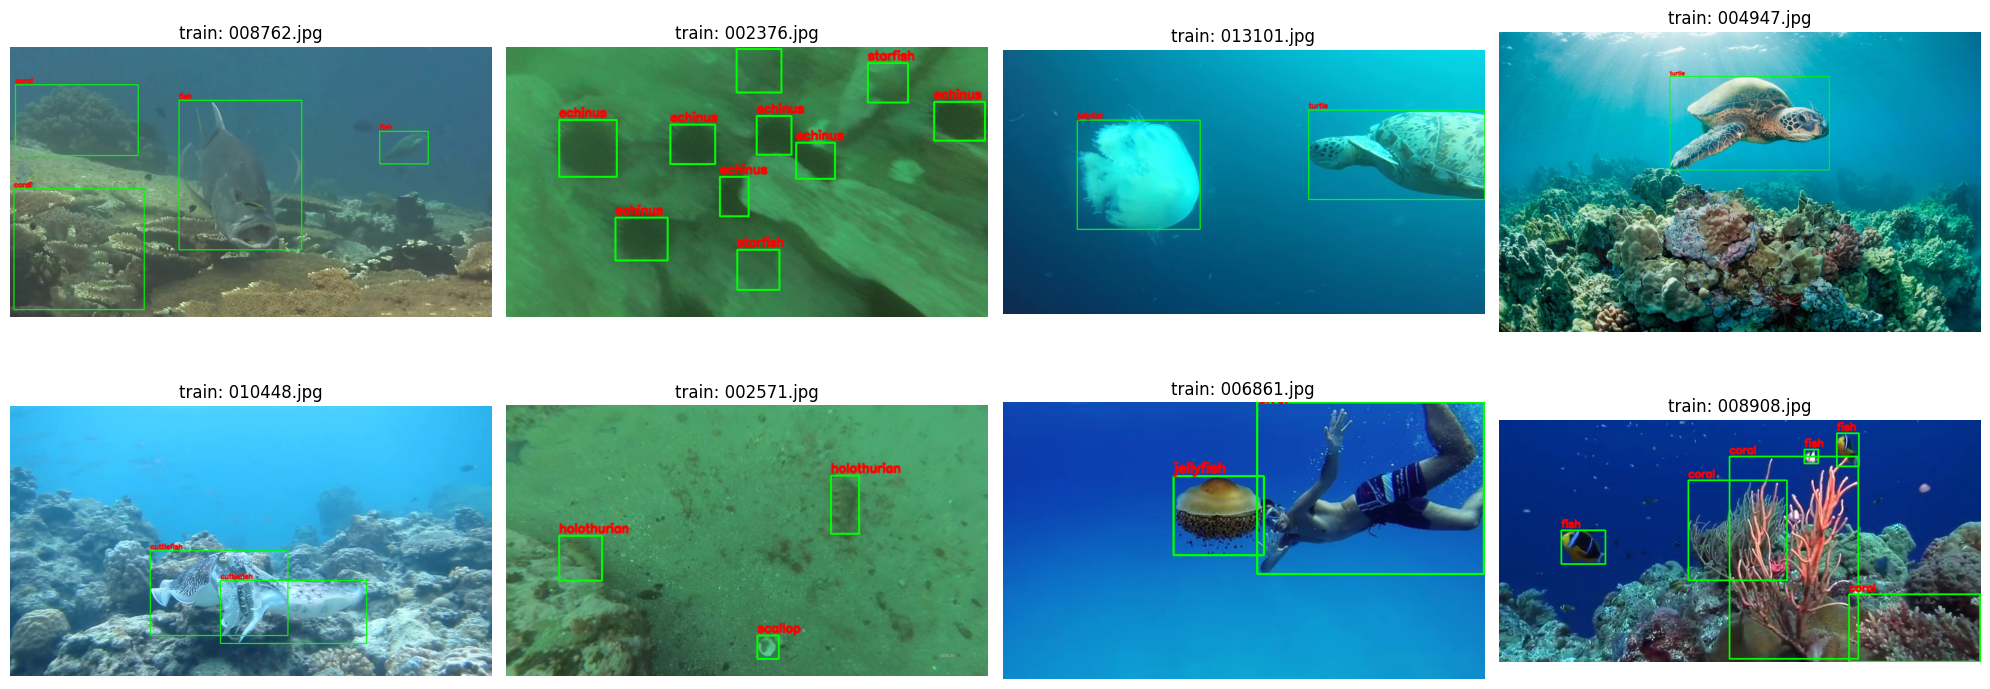

In [11]:
import os, math, random, re
from pathlib import Path
import cv2
import matplotlib.pyplot as plt

# ---------------- config ----------------
DATA_ROOT = Path("data/RUOD")
IMG_ROOT  = DATA_ROOT / "RUOD_pic"
LAB_ROOT  = DATA_ROOT / "labels"

SPLIT = "train"   # "train" or "test"
IMG_DIR = IMG_ROOT / SPLIT
LAB_DIR = LAB_ROOT / SPLIT

NUM_PICS = 8
COLS = 4

# RUOD class names (index must match IDs in .txt files)
RUOD_NAMES = [
    "holothurian","echinus","scallop","starfish","fish",
    "coral","diver","cuttlefish","turtle","jellyfish"
]
# ----------------------------------------

def find_images(folder: Path):
    exts = (".jpg",".jpeg",".png",".bmp",".tif",".tiff")
    return [p for p in folder.rglob("*") if p.suffix.lower() in exts]

def label_path_for(img_path: Path) -> Path:
    return LAB_DIR / (img_path.stem + ".txt")

def draw_yolo_labels(image_bgr, label_file: Path, names):
    img = image_bgr.copy()
    h, w = img.shape[:2]
    if not label_file.exists():
        return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    for line in label_file.read_text().splitlines():
        line = line.strip()
        if not line:
            continue
        # YOLO format: class cx cy w h (normalized 0..1)
        parts = re.split(r"\s+", line)
        if len(parts) < 5:
            continue
        cls = int(float(parts[0]))
        cx, cy, bw, bh = map(float, parts[1:5])

        x1 = int((cx - bw/2) * w); y1 = int((cy - bh/2) * h)
        x2 = int((cx + bw/2) * w); y2 = int((cy + bh/2) * h)
        x1 = max(0, min(w-1, x1)); y1 = max(0, min(h-1, y1))
        x2 = max(0, min(w-1, x2)); y2 = max(0, min(h-1, y2))

        color = (0,255,0)
        cv2.rectangle(img, (x1,y1), (x2,y2), color, 2)
        label = names[cls] if 0 <= cls < len(names) else f"id{cls}"
        cv2.putText(img, label, (x1, max(0, y1-5)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,0,255), 2, cv2.LINE_AA)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# collect images that exist (optionally: require label file exists too)
all_imgs = find_images(IMG_DIR)
imgs_with_labels = [p for p in all_imgs if label_path_for(p).exists()]
pool = imgs_with_labels if imgs_with_labels else all_imgs

if not pool:
    raise FileNotFoundError(f"No images found in {IMG_DIR}")

sample_ids = random.sample(pool, min(NUM_PICS, len(pool)))
rows = math.ceil(len(sample_ids) / COLS)

plt.figure(figsize=(5*COLS, 4*rows))
for idx, img_path in enumerate(sample_ids, 1):
    img_bgr = cv2.imread(str(img_path))
    if img_bgr is None:
        continue
    lab_path = label_path_for(img_path)
    vis = draw_yolo_labels(img_bgr, lab_path, RUOD_NAMES)

    plt.subplot(rows, COLS, idx)
    plt.imshow(vis)
    plt.axis("off")
    plt.title(f"{SPLIT}: {img_path.name}")
plt.tight_layout(); plt.show()


# Building

Building (and training) of the model happens in [train.py](./train.py). The model is constructed by the [uw_yolov8.yaml](./models/uw_yolov8.yaml), that imports modules from [custom blocks](#adding-custom-blocks). 


### Adding custom blocks

I have added custom blocks to match the architecture as pruposed in the paper. For this to work I have first cloned the ultralytics repo.
- Head to [ultralytics](https://docs.ultralytics.com/guides/model-yaml-config/#source-code-modification) to see how to add custom blocks.
- Files that is modified: [block.py](../ultralytics/ultralytics/nn/modules/block.py) [tasks.py](../ultralytics/ultralytics/nn/tasks.py), [__init__.py](../ultralytics/ultralytics/nn/modules/__init__.py)



### Is it an accurate replication??

Yes should be pretty good now. But a lot of paramters!?

# Training

- To train the model run the train.py script by doing: python3 train.py

### How I did training

- Using the IDUN computer at NTNU. 

- Loaded the pretrained yolov8s to make training faster. 
